# IBM Capstone Project: The Battle of the Neighborhoods

## Resturant opening in Romania

In [2]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

     |████████████████████████████████| 102kB 6.3MB/s ta 0:00:011
     |████████████████████████████████| 102kB 7.5MB/s ta 0:00:011


In [3]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


In [4]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


In [5]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))

There are 40 neighborhoods in Bucharest, Romania


In [6]:
# Read Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_address))
df_sector

There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


In [7]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


In [8]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.485790,26.101220
1,Băneasa,Sector 1,"225,454",44.494010,26.080372
2,Berceni,Sector 4,"287,828",44.386200,26.128960
3,Bucureștii Noi,Sector 1,"225,454",44.484495,26.039608
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660


In [9]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

In [ ]:
# define Foursquare Credentials and Version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200824' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [11]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 228 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.10122,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.10122,ibis Styles Bucharest Erbas,5bbb782175dcb7002cc15ee7,44.483963,26.097134,382,Hotel
2,Aviației,44.48579,26.10122,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
3,Aviației,44.48579,26.10122,ORYGYNS Specialty Coffee,5807575ed67ca95d8cf5ccb9,44.480010,26.100450,646,Coffee Shop
4,Aviației,44.48579,26.10122,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop


In [12]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Café,70
Restaurant,65
Italian Restaurant,59
Coffee Shop,59
Supermarket,57
Pizza Place,47
Gym,46
Romanian Restaurant,40
Hotel,40


In [13]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 495
Total number of Turkish restaurants: 22
Percentage of Turkish restaurants: 4.44%


20 neighborhoods do not have any Turkish restaurant


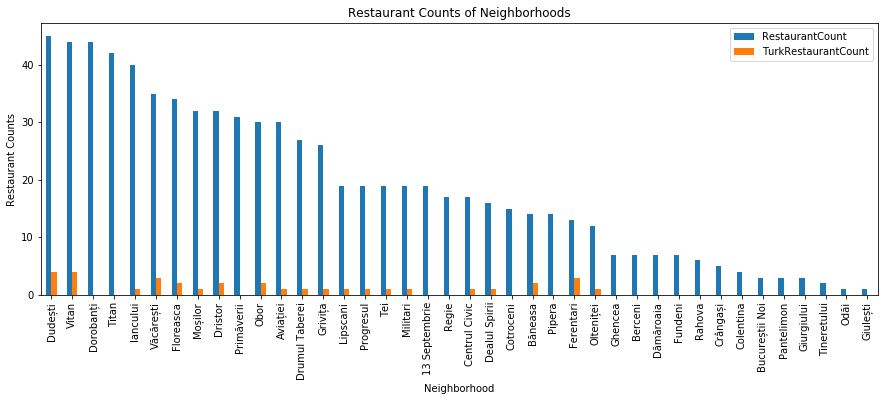

In [14]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Turkish restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In [19]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,None,None
1,53623e44498ed583ede334f5,None,None
2,55b8a459498efbbb6ca3526d,None,None
3,58bbf8764f1069627380fed5,None,None
4,59ee47be0d8a0f244d41fca7,None,None


In [20]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.48579,26.101220,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,None,None
1,Floreasca,44.47633,26.103279,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,349,Burger Joint,None,None
2,Aviației,44.48579,26.101220,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,None,None
3,Floreasca,44.47633,26.103279,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,228,Restaurant,None,None
4,Aviației,44.48579,26.101220,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,844,Vietnamese Restaurant,None,None


In [21]:
#merge raitings to turkish restaurants 
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.48579,26.101220,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,825,Turkish Restaurant,None,None
1,Floreasca,44.47633,26.103279,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,248,Turkish Restaurant,None,None
2,Băneasa,44.49401,26.080372,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.494460,26.080462,50,Doner Restaurant,None,None
3,Băneasa,44.49401,26.080372,Mister Kebab,55cc98e7498eb1362730ea27,44.493982,26.082630,179,Doner Restaurant,None,None
4,Centrul Civic,44.43430,26.094660,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,656,Doner Restaurant,None,None


In [22]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

In [23]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

In [24]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 228 columns as below


,Neighborhood,Supermarket,Hotel,Coffee Shop,Burger Joint,Dessert Shop,Grocery Store,Roof Deck,Beer Garden,Restaurant,Gym / Fitness Center,Vietnamese Restaurant,Salad Place,Salon / Barbershop,Shopping Mall,Pie Shop,Bookstore,Café,Steakhouse,Sushi Restaurant,Italian Restaurant,Clothing Store,Toy / Game Store,Turkish Restaurant,Bakery,Sandwich Place,Lebanese Restaurant,Casino,Spanish Restaurant,Pizza Place,Middle Eastern Restaurant,Event Space,Indoor Play Area,Fried Chicken Joint,Lounge,Eastern European Restaurant,Stadium,Romanian Restaurant,Tennis Stadium,Mongolian Restaurant,Ice Cream Shop,Sporting Goods Shop,Cocktail Bar,Gym,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Nightclub,Theme Restaurant,Tunnel,Farmers Market,Bed & Breakfast,Airport Terminal,Soccer Field,Spa,Nature Preserve,Fast Food Restaurant,Food & Drink Shop,Electronics Store,Fountain,Betting Shop,Pharmacy,Gas Station,Mobile Phone Shop,Gym Pool,Dog Run,Theater,Gastropub,Outdoor Sculpture,Bistro,Indie Theater,Monastery,Skating Rink,Used Bookstore,Chocolate Shop,Art Museum,Tea Room,Plaza,Beer Bar,Wine Bar,Concert Hall,Bar,Cosmetics Shop,Swiss Restaurant,Rock Club,Hostel,History Museum,Art Gallery,Historic Site,Church,Mediterranean Restaurant,Hardware Store,Discount Store,Antique Shop,Arts & Crafts Store,Herbs & Spices Store,Bus Station,Furniture / Home Store,Gift Shop,Tennis Court,Jazz Club,Accessories Store,Opera House,Market,Pedestrian Plaza,Hotel Bar,Music Store,Indian Restaurant,Pub,Pool,Garden,Indie Movie Theater,Australian Restaurant,Shoe Store,Light Rail Station,French Restaurant,Cupcake Shop,Climbing Gym,Department Store,Soccer Stadium,Convenience Store,Miscellaneous Shop,Donut Shop,Outlet Mall,Intersection,Japanese Restaurant,Fish Market,Scandinavian Restaurant,Juice Bar,Cheese Shop,Asian Restaurant,Modern European Restaurant,Seafood Restaurant,Fruit & Vegetable Store,German Restaurant,Molecular Gastronomy Restaurant,Wine Shop,American Restaurant,Hookah Bar,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Chinese Restaurant,Skate Park,Greek Restaurant,Metro Station,Jewelry Store,ATM,Water Park,Brewery,Ballroom,Diner,Health Food Store,Auto Dealership,Platform,Portuguese Restaurant,Science Museum,Lingerie Store,Cable Car,Sports Club,Tram Station,Athletics & Sports,Bagel Shop,Museum,Health & Beauty Service,Food Truck,Buffet,Business Service,Movie Theater,Factory,Kebab Restaurant,Exhibit,Snack Place,Public Art,Pool Hall,Dance Studio,Tattoo Parlor,Gourmet Shop,Hospital,Palace,Falafel Restaurant,Cultural Center,Football Stadium,Print Shop,BBQ Joint,Big Box Store,Hungarian Restaurant,Karaoke Bar,Food Court,Optical Shop,Beach,Auto Garage,Theme Park,Martial Arts School,Veterinarian,Theme Park Ride / Attraction,Laser Tag,Shop & Service,Bowling Alley,Women's Store,Train Station,Go Kart Track,Souvlaki Shop,Track,Recreation Center,Bike Shop,Creperie,Memorial Site,Korean Restaurant,Mexican Restaurant,Basketball Court,Paper / Office Supplies Store,Sports Bar,Laundromat,Lighting Store,Comfort Food Restaurant,Taco Place,Fish & Chips Shop,Recording Studio,Soup Place,Circus,Boutique,Pet Café,Leather Goods Store,Gaming Cafe,Camera Store
0,13 Septembrie,1,3,3,0,1,1,0,0,5,2,0,0,0,0,0,0,3,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,2,0,0,2,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,2,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,0,0,0,0,0
1,Aviației,4,4,4,3,2,1,1,1,5,2,1,1,1,1,1,1,5,3,2,1,2,1,1,4,1,2,1,1,4,1,1,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [25]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,66,Restaurant,Hotel,Coffee Shop,Pub,Café,Plaza,Lounge,Seafood Restaurant,Gym / Fitness Center,Comfort Food Restaurant
1,Aviației,76,Restaurant,Café,Supermarket,Bakery,Pizza Place,Hotel,Coffee Shop,Steakhouse,Burger Joint,Dessert Shop
2,Berceni,22,Pizza Place,Grocery Store,Gym / Fitness Center,Food & Drink Shop,Fast Food Restaurant,Park,Gym,Lebanese Restaurant,Farmers Market,Nature Preserve
3,Bucureștii Noi,19,Supermarket,Grocery Store,Gym,Pharmacy,Gas Station,Mobile Phone Shop,Gym Pool,Restaurant,Dog Run,Theater
4,Băneasa,30,Hotel,Restaurant,Park,Romanian Restaurant,Italian Restaurant,Doner Restaurant,Soccer Field,Farmers Market,Bed & Breakfast,Airport Terminal


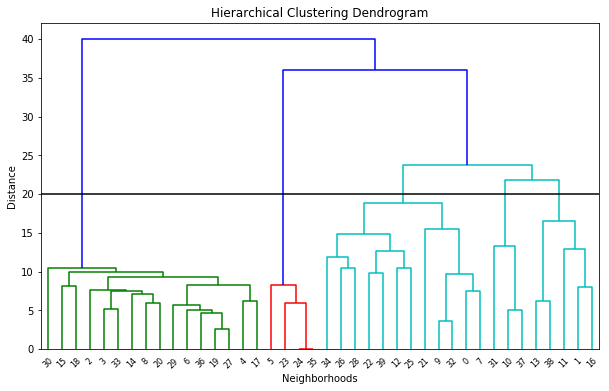

In [26]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [27]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.485790,26.101220,0,Restaurant,Café,Supermarket
1,Băneasa,Sector 1,"225,454",44.494010,26.080372,3,Hotel,Restaurant,Park
2,Berceni,Sector 4,"287,828",44.386200,26.128960,3,Pizza Place,Grocery Store,Gym / Fitness Center
3,Bucureștii Noi,Sector 1,"225,454",44.484495,26.039608,3,Supermarket,Grocery Store,Gym
4,Centrul Civic,Sector 3,"385,439",44.434300,26.094660,5,Coffee Shop,Hotel,Wine Bar


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [29]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                    
0                   Café                                         2
                    Coffee Shop                                  1
                    Pizza Place                                  1
                    Restaurant                                   1
1                   Coffee Shop                                  1
                    Hotel                                        1
                    Restaurant                                   3
2                   Café                                         1
                    Italian Restaurant                           3
                    Pizza Place                                  1
                    Pub                                          1
                    Supermarket                                  1
3                   Burger Joint                              

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Café                                         1
                    Gym / Fitness Center                         1
                    Restaurant                                   1
                    Supermarket                                  2
1                   Hotel                                        1
                    Pub                                          1
                    Restaurant                                   1
                    Supermarket                                  2
2                   Café                                         1
                    Gym                                          2
                    Italian Restaurant                           1
                    Supermarket                                  3
3                   Auto Garage                                  1
                    Bar                                          1
                    Go Kart Track                                1
                    Grocery Store                                2
                    Gym                                          1
                    Gym / Fitness Center                         1
                    Middle Eastern Restaurant                    1
                    Park                                         2
                    Pedestrian Plaza                             1
                    Restaurant                                   2
                    Supermarket                                  3
4                   Coffee Shop                                  2
                    Lounge                                       1
5                   Hotel                                        4

__We can see cluster categories as below__

Cluster 0 (Red) : Italian Restaurant , Pizza, Café
Cluster 1 (Purple) : Restaurant , Bar
Cluster 2 (BLue) : Park , Plaza, Clothing stores
Cluster 3 (Cyan) : Coffee Shop, Hotel, Pub
Cluster 4 (Green) : Café, Suprmarket
Cluster 5 (Orange) : Café 

# Discussion



Cluster 2 suffers from restaurant. Especially there is no Turkish restaurant in west part inluding Cluster 2 . We can think about Cluster 2 , West part

Cluster 0 especially likes Itallian tastes , may be this part will not like Turkish tastes . We can only think about 1 location may be .

Cluster 1, 2, 3 are centers full of restaurants as we saw in the heatmap also


# Conclusion

Possible Neighborhoods to set up a Turkish restaurant :

• Neighborhood : Regie , Cluster 0, Sector 6 , Population : 367760

I choosed Regie , since west part of Bucharest has not Turkish restaurant and Regie is close to center . Regie is red cluster which is same with the other 2 red markers having Turk restaurant. Red clusters populations may like Turkish food. 

• Neighborhood : Bucureștii Noi , Cluster 2, Sector 1 , Population : 225453

I choosed Bucharest-noi , since west part of Bucharest has not Turkish restaurant and even not too much restaurant after 6 km distance to center . One restaurant will be good for this area.

• Neighborhood : Crângași , Cluster 2, Sector 6 , Population : 367760

I choosed Crangasi , since Crangasi  and west part of Bucharest has not Turkish restaurant and from bar chart we can see that this neighborhood has not too much restaurant. Also this neighborhood is in Sector 6 and this sector has biggest population which will handle one more restaurant 

• Neighborhood : Tineretului , Cluster 2, Sector 4 , Population : 287828

I choosed Tineretului , since Tineretului has not Turkish restaurant and from bar chart we can see that this neighborhood has not too much restaurant. 

